In [1]:
# - Rockpool
from rockpool.nn.modules import LinearJax
from rockpool.nn.combinators import Sequential

# - Numpy
import jax.random as rand
import numpy as np

# T- QDM
from tqdm.autonotebook import tqdm

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

Could not import package: No module named 'iaf_nest'


In [2]:
# - Generate a network as a sequence
rec_shape = (3,5,4)
rng_key = rand.PRNGKey(0)
w_rec = rand.uniform(rng_key, rec_shape)
w_rec = w_rec.flatten()
w_rec

DeviceArray([0.12447917, 0.1094259 , 0.23693919, 0.94575596, 0.1594727 ,
             0.84554565, 0.01326525, 0.37130654, 0.34224176, 0.6253567 ,
             0.7081952 , 0.16291368, 0.29458654, 0.00194848, 0.5491575 ,
             0.8475604 , 0.925928  , 0.54306674, 0.40060925, 0.8868216 ,
             0.95004666, 0.51836514, 0.63809705, 0.06671274, 0.6426624 ,
             0.31780863, 0.21331525, 0.2628814 , 0.25734162, 0.72351336,
             0.062621  , 0.16465926, 0.02687132, 0.1529026 , 0.25560737,
             0.03544354, 0.31713212, 0.33358395, 0.948547  , 0.93193233,
             0.73810947, 0.20734286, 0.13556743, 0.57623744, 0.05131841,
             0.8201177 , 0.5338551 , 0.8530345 , 0.96546125, 0.9175153 ,
             0.33442986, 0.95699656, 0.95403767, 0.92046404, 0.5596161 ,
             0.42783093, 0.9162421 , 0.4420396 , 0.6804645 , 0.46406043],            dtype=float32)

In [3]:
N = 4
AutoEncoder = Sequential(
    LinearJax((60, N), weight = np.random.rand(60, N)),
    LinearJax((N, 60), weight = np.random.rand(N, 60)),
)

In [4]:
AutoEncoder

JaxSequential  with shape (60, 60) {
    LinearJax '0_LinearJax' with shape (60, 4)
    LinearJax '1_LinearJax' with shape (4, 60)
}

In [5]:
from rockpool.training.jax_loss import bounds_cost, make_bounds

# - Generate a set of pre-configured bounds
lower_bounds, upper_bounds = make_bounds(AutoEncoder.parameters())
print('lower_bounds: ', lower_bounds,
      'upper_bounds: ', upper_bounds)

lower_bounds:  {'0_LinearJax': {'bias': -inf, 'weight': -inf}, '1_LinearJax': {'bias': -inf, 'weight': -inf}} upper_bounds:  {'0_LinearJax': {'bias': inf, 'weight': inf}, '1_LinearJax': {'bias': inf, 'weight': inf}}


In [6]:
lower_bounds['0_LinearJax']['weight'] = 0
lower_bounds['1_LinearJax']['weight'] = 0

In [7]:
print('lower_bounds: ', lower_bounds,
      'upper_bounds: ', upper_bounds)

lower_bounds:  {'0_LinearJax': {'bias': -inf, 'weight': 0}, '1_LinearJax': {'bias': -inf, 'weight': 0}} upper_bounds:  {'0_LinearJax': {'bias': inf, 'weight': inf}, '1_LinearJax': {'bias': inf, 'weight': inf}}


In [8]:
# - Define a constrained MSE loss function
import rockpool.training.jax_loss as l

def loss_mse(parameters, net, inputs, target):
    # - Handle the network state — randomise or reset
    # print("\t Reset State:")
    net = net.reset_state()

    # print("\t Set Attributes:")
    # - Assign the provided parameters to the network
    net = net.set_attributes(parameters)


    # print("\t Evolve:")
    # - Evolve the network to get the ouput
    output, _, _ = net(inputs)

    # print("\t Bounds:")
    # - Impose the bounds
    bounds = bounds_cost(parameters, lower_bounds, upper_bounds) * 1e3

    # print("\t Done!")
    # - Compute a loss value w.r.t. the target output
    return l.mse(output, target) + bounds

In [9]:
# - Useful imports
from tqdm.autonotebook import tqdm
from copy import deepcopy
from itertools import count

# -- Import an optimiser to use and initalise it
import jax
from jax.experimental.optimizers import adam

# - Get the optimiser functions
init_fun, update_fun, get_params = adam(1e-3)

# - Initialise the optimiser with the initial parameters
params0 = deepcopy(AutoEncoder.parameters())
opt_state = init_fun(params0)

# - Get a compiled value-and-gradient function
loss_vgf = jax.jit(jax.value_and_grad(loss_mse))

# - Compile the optimiser update function
update_fun = jax.jit(update_fun)

# - Record the loss values over training iterations
loss_t = []
grad_t = []

num_epochs = 10000

# - Loop over iterations
i_trial = count()
pbar = tqdm(range(num_epochs))
for _ in pbar:
    # - Get parameters for this iteration
    params = get_params(opt_state)

    # - Get the loss value and gradients for this iteration
    loss_val, grads = loss_vgf(params, AutoEncoder, w_rec, w_rec)

    # - Update the optimiser
    opt_state = update_fun(next(i_trial), grads, opt_state)

    # - Keep track of the loss
    loss_t.append(loss_val)
    pbar.set_postfix({'loss': loss_val})

100%|██████████| 10000/10000 [00:16<00:00, 610.12it/s, loss=3.7744443e-12]


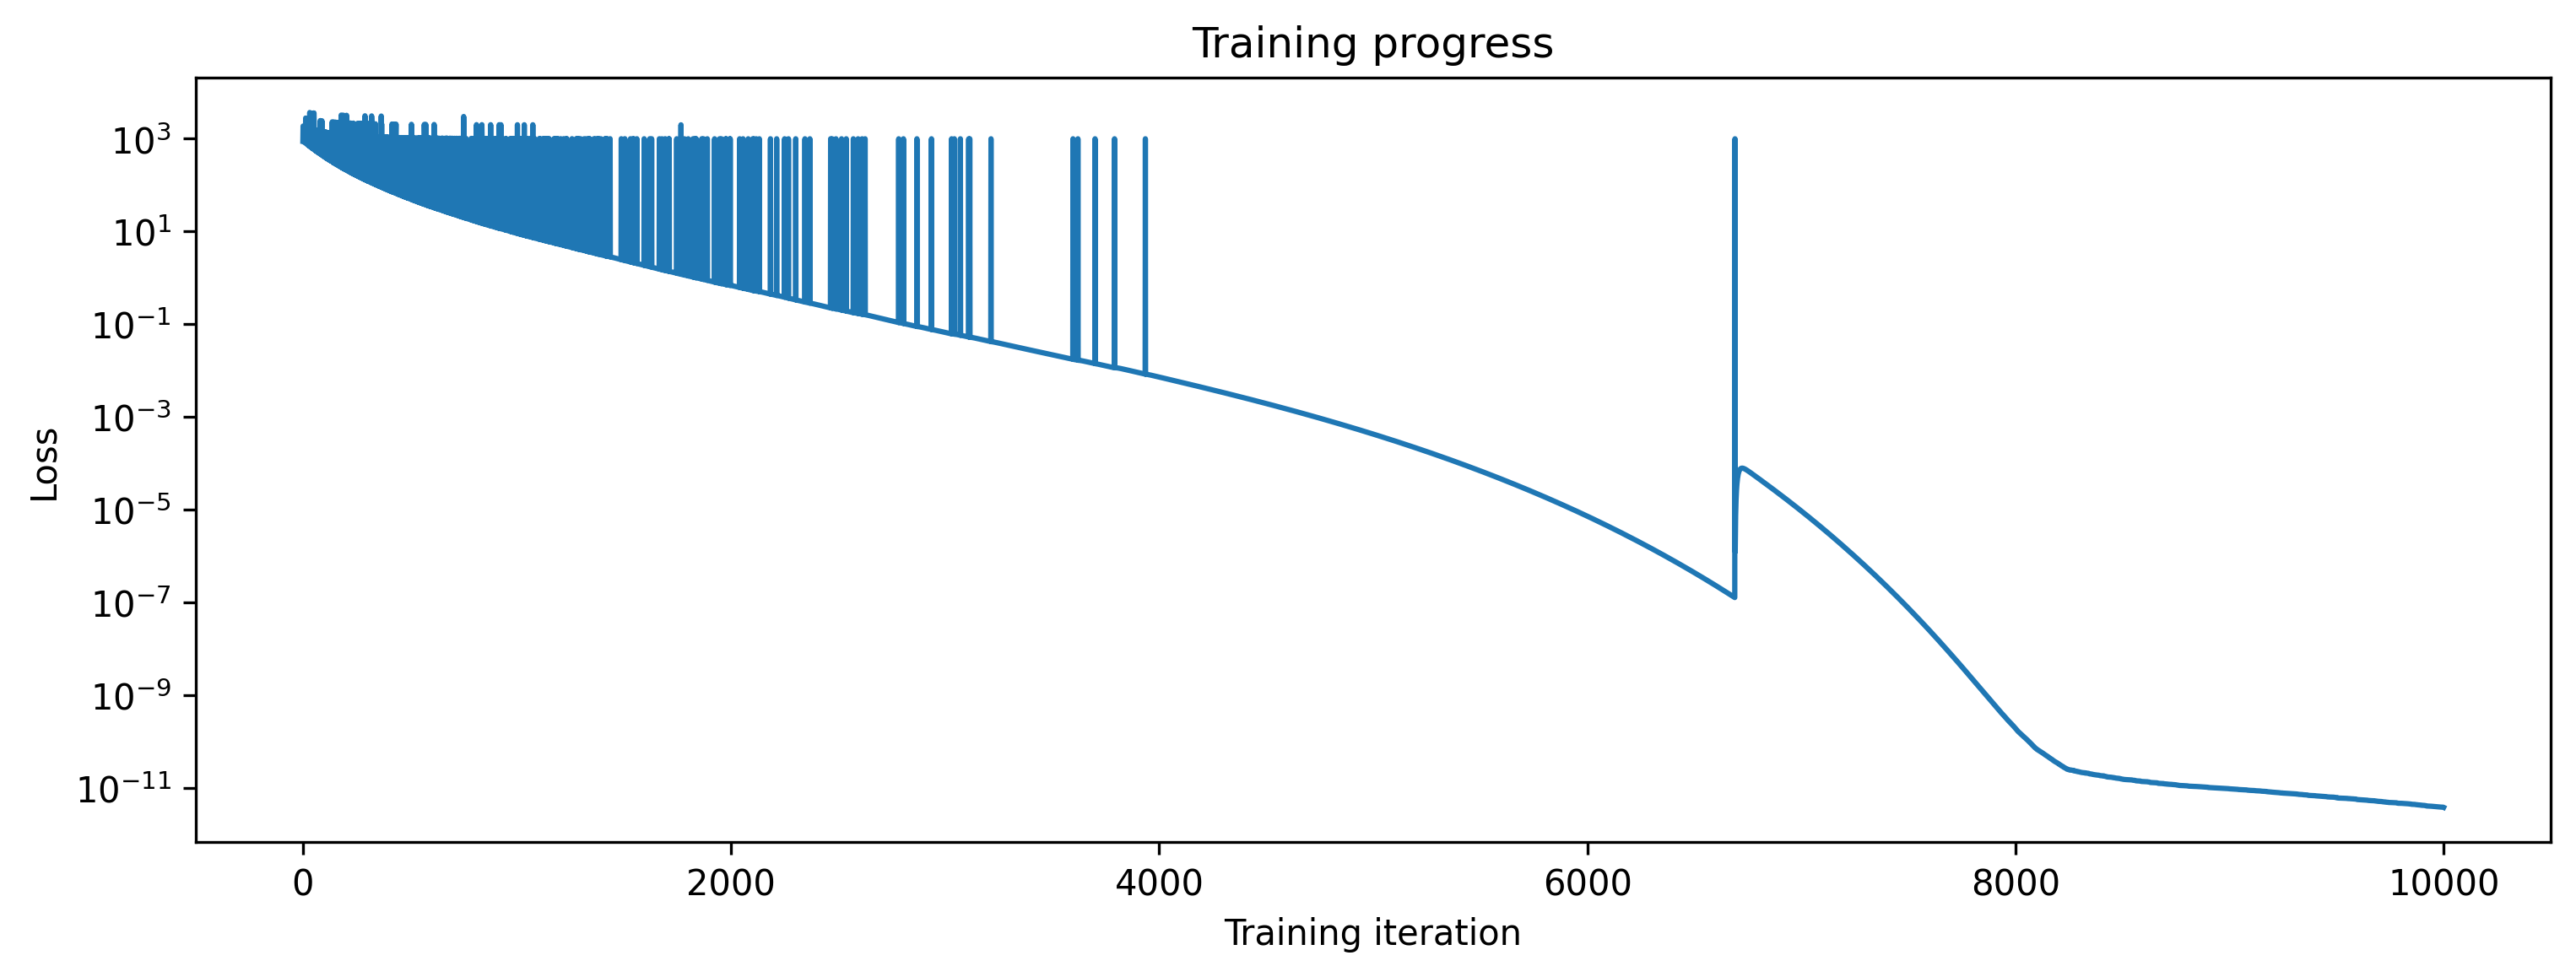

In [10]:
plt.figure()
plt.plot(loss_t)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training iteration');
plt.title('Training progress');

In [11]:
AutoEncoder2 = AutoEncoder.set_attributes(get_params(opt_state))

In [12]:
w_rec

DeviceArray([0.12447917, 0.1094259 , 0.23693919, 0.94575596, 0.1594727 ,
             0.84554565, 0.01326525, 0.37130654, 0.34224176, 0.6253567 ,
             0.7081952 , 0.16291368, 0.29458654, 0.00194848, 0.5491575 ,
             0.8475604 , 0.925928  , 0.54306674, 0.40060925, 0.8868216 ,
             0.95004666, 0.51836514, 0.63809705, 0.06671274, 0.6426624 ,
             0.31780863, 0.21331525, 0.2628814 , 0.25734162, 0.72351336,
             0.062621  , 0.16465926, 0.02687132, 0.1529026 , 0.25560737,
             0.03544354, 0.31713212, 0.33358395, 0.948547  , 0.93193233,
             0.73810947, 0.20734286, 0.13556743, 0.57623744, 0.05131841,
             0.8201177 , 0.5338551 , 0.8530345 , 0.96546125, 0.9175153 ,
             0.33442986, 0.95699656, 0.95403767, 0.92046404, 0.5596161 ,
             0.42783093, 0.9162421 , 0.4420396 , 0.6804645 , 0.46406043],            dtype=float32)

In [13]:
AutoEncoder2(w_rec)

(DeviceArray([0.12448096, 0.10942674, 0.23694098, 0.94575644, 0.15947282,
              0.84554595, 0.01326734, 0.37130624, 0.34224164, 0.6253573 ,
              0.70818937, 0.16291034, 0.2945882 , 0.00195003, 0.5491572 ,
              0.84756076, 0.925929  , 0.54306823, 0.4006096 , 0.8868228 ,
              0.9500457 , 0.5183658 , 0.63809264, 0.06671053, 0.64266235,
              0.3178088 , 0.21331823, 0.26288116, 0.25733984, 0.7235142 ,
              0.06262243, 0.16465878, 0.02687764, 0.15290004, 0.2556061 ,
              0.03544223, 0.31713283, 0.3335824 , 0.9485467 , 0.931931  ,
              0.7381096 , 0.20734346, 0.1355676 , 0.5762356 , 0.0513193 ,
              0.8201203 , 0.5338554 , 0.85303146, 0.9654614 , 0.9175152 ,
              0.33442986, 0.9569932 , 0.9540397 , 0.92046446, 0.5596174 ,
              0.4278279 , 0.9162414 , 0.44204026, 0.68046623, 0.46405685],            dtype=float32),
 {'0_LinearJax': {}, '1_LinearJax': {}},
 {'0_LinearJax': {},
  '0_LinearJax_output'

In [14]:
AutoEncoder.__getattribute__("0_LinearJax").weight

array([[0.13974495, 0.89934619, 0.7427753 , 0.89122216],
       [0.44894005, 0.80669851, 0.7273898 , 0.65693106],
       [0.33048554, 0.68902837, 0.67671005, 0.41476539],
       [0.37687655, 0.78442217, 0.16135343, 0.17896687],
       [0.9011094 , 0.02752732, 0.11745807, 0.35971857],
       [0.80839186, 0.32789547, 0.66891642, 0.7746013 ],
       [0.66674017, 0.9994137 , 0.84892386, 0.35168927],
       [0.97049896, 0.96920979, 0.8507781 , 0.9226474 ],
       [0.9535244 , 0.09095365, 0.26234566, 0.75379115],
       [0.16582255, 0.45456685, 0.3020449 , 0.15180077],
       [0.62543958, 0.05573626, 0.56604131, 0.65829589],
       [0.12187828, 0.96549   , 0.3221581 , 0.49962544],
       [0.8718221 , 0.15425314, 0.17489929, 0.7848212 ],
       [0.67623799, 0.19843797, 0.16523338, 0.69527201],
       [0.63433421, 0.0374712 , 0.54336162, 0.76441675],
       [0.49673246, 0.97315791, 0.62641954, 0.66637625],
       [0.54240531, 0.87921311, 0.98123091, 0.19368574],
       [0.71932561, 0.9122028 ,

In [13]:
from jax import random as rand
from jax import numpy as jnp
rng_key = rand.PRNGKey(0)
rec_shape = (3,5,4)
_w = rand.normal(rng_key, rec_shape) * 1e-6
jnp.clip(_w, 0)

DeviceArray([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
               1.6050259e-06],
              [0.0000000e+00, 1.0175145e-06, 0.0000000e+00,
               0.0000000e+00],
              [0.0000000e+00, 3.1958012e-07, 5.4811994e-07,
               0.0000000e+00],
              [0.0000000e+00, 0.0000000e+00, 1.2353304e-07,
               1.0260262e-06],
              [1.4461186e-06, 1.0816283e-07, 0.0000000e+00,
               1.2097972e-06]],

             [[1.6453062e-06, 4.6050854e-08, 3.5337692e-07,
               0.0000000e+00],
              [3.6558447e-07, 0.0000000e+00, 0.0000000e+00,
               0.0000000e+00],
              [0.0000000e+00, 5.9331063e-07, 0.0000000e+00,
               0.0000000e+00],
              [0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
               0.0000000e+00],
              [0.0000000e+00, 0.0000000e+00, 1.6309258e-06,
               1.4903381e-06]],

             [[6.3752788e-07, 0.0000000e+00, 0.0000000e+00,
               1.9227713e-